# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [150]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones

train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты, будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [226]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):

    assert x.shape == (2,)
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


True

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [225]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [224]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
linear_classifer.cross_entropy_loss(probs, 1)

15.020281330641362

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [223]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], np.float))

Gradient check passed!


True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [222]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Make sure maximum subtraction for numberic stability is done separately for every sample in the batch
probs = linear_classifer.softmax(np.array([[20,0,0], [1000, 0, 0]]))
assert np.all(np.isclose(probs[:, 0], 1.0))

Gradient check passed!
Gradient check passed!


### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [221]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

Gradient check passed!


True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [220]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [205]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)

Epoch 0, loss: 2.484281
Epoch 1, loss: 2.356141
Epoch 2, loss: 2.318005
Epoch 3, loss: 2.306667
Epoch 4, loss: 2.303311
Epoch 5, loss: 2.302290
Epoch 6, loss: 2.302003
Epoch 7, loss: 2.301899
Epoch 8, loss: 2.301873
Epoch 9, loss: 2.301866


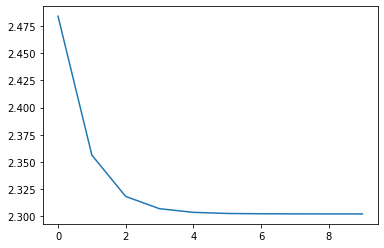

In [206]:
# let's look at the loss history!
plt.plot(loss_history)

In [207]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Accuracy:  0.117
Epoch 0, loss: 2.301864
Epoch 1, loss: 2.301868
Epoch 2, loss: 2.301864
Epoch 3, loss: 2.301867
Epoch 4, loss: 2.301854
Epoch 5, loss: 2.301886
Epoch 6, loss: 2.301853
Epoch 7, loss: 2.301878
Epoch 8, loss: 2.301858
Epoch 9, loss: 2.301856
Epoch 10, loss: 2.301871
Epoch 11, loss: 2.301860
Epoch 12, loss: 2.301867
Epoch 13, loss: 2.301861
Epoch 14, loss: 2.301875
Epoch 15, loss: 2.301877
Epoch 16, loss: 2.301859
Epoch 17, loss: 2.301867
Epoch 18, loss: 2.301860
Epoch 19, loss: 2.301861
Epoch 20, loss: 2.301860
Epoch 21, loss: 2.301876
Epoch 22, loss: 2.301860
Epoch 23, loss: 2.301850
Epoch 24, loss: 2.301853
Epoch 25, loss: 2.301863
Epoch 26, loss: 2.301889
Epoch 27, loss: 2.301870
Epoch 28, loss: 2.301860
Epoch 29, loss: 2.301864
Epoch 30, loss: 2.301846
Epoch 31, loss: 2.301869
Epoch 32, loss: 2.301875
Epoch 33, loss: 2.301854
Epoch 34, loss: 2.301867
Epoch 35, loss: 2.301863
Epoch 36, loss: 2.301852
Epoch 37, loss: 2.301867
Epoch 38, loss: 2.301870
Epoch 39, loss: 2.

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [209]:
num_epochs = 200
batch_size = 300

learning_rates = [1e-3, 1e-4, 1e-2, 1e-6, 1e-7]
reg_strengths = [1e-4, 1e-5, 1e-6, 1e-3, 1e-2, 0.1, 1, 10, 30, 100]


i = 0
best_classifier = linear_classifer.LinearSoftmaxClassifier()
accuracies = []
hyper_params = []

for lr in learning_rates:
    for rs in reg_strengths:
        classifier = linear_classifer.LinearSoftmaxClassifier()
        classifier.fit(train_X, train_y, epochs=num_epochs, learning_rate=lr, batch_size=batch_size, reg=rs)
        pred = classifier.predict(val_X)
        accuracy = multiclass_accuracy(pred, val_y)
        print(accuracy)
                
        if not accuracies or all(accuracy > accuracies):
            best_classifier = classifier
            
        accuracies.append(accuracy)
        hyper_params.append((lr, rs))
        i += 1

best_val_accuracy = np.max(accuracies)

# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially

print('best validation accuracy achieved: %f' % best_val_accuracy)

Epoch 0, loss: 2.302297
Epoch 1, loss: 2.301231
Epoch 2, loss: 2.300223
Epoch 3, loss: 2.299277
Epoch 4, loss: 2.298340
Epoch 5, loss: 2.297438
Epoch 6, loss: 2.296552
Epoch 7, loss: 2.295677
Epoch 8, loss: 2.294801
Epoch 9, loss: 2.293934
Epoch 10, loss: 2.293101
Epoch 11, loss: 2.292271
Epoch 12, loss: 2.291427
Epoch 13, loss: 2.290626
Epoch 14, loss: 2.289788
Epoch 15, loss: 2.289003
Epoch 16, loss: 2.288188
Epoch 17, loss: 2.287395
Epoch 18, loss: 2.286611
Epoch 19, loss: 2.285820
Epoch 20, loss: 2.285043
Epoch 21, loss: 2.284282
Epoch 22, loss: 2.283516
Epoch 23, loss: 2.282758
Epoch 24, loss: 2.282009
Epoch 25, loss: 2.281273
Epoch 26, loss: 2.280525
Epoch 27, loss: 2.279794
Epoch 28, loss: 2.279061
Epoch 29, loss: 2.278310
Epoch 30, loss: 2.277611
Epoch 31, loss: 2.276900
Epoch 32, loss: 2.276192
Epoch 33, loss: 2.275480
Epoch 34, loss: 2.274787
Epoch 35, loss: 2.274084
Epoch 36, loss: 2.273409
Epoch 37, loss: 2.272715
Epoch 38, loss: 2.272056
Epoch 39, loss: 2.271359
Epoch 40, 

Epoch 124, loss: 2.226972
Epoch 125, loss: 2.226569
Epoch 126, loss: 2.226168
Epoch 127, loss: 2.225770
Epoch 128, loss: 2.225378
Epoch 129, loss: 2.224991
Epoch 130, loss: 2.224605
Epoch 131, loss: 2.224198
Epoch 132, loss: 2.223805
Epoch 133, loss: 2.223459
Epoch 134, loss: 2.223053
Epoch 135, loss: 2.222674
Epoch 136, loss: 2.222280
Epoch 137, loss: 2.221913
Epoch 138, loss: 2.221556
Epoch 139, loss: 2.221161
Epoch 140, loss: 2.220804
Epoch 141, loss: 2.220430
Epoch 142, loss: 2.220066
Epoch 143, loss: 2.219705
Epoch 144, loss: 2.219340
Epoch 145, loss: 2.218965
Epoch 146, loss: 2.218623
Epoch 147, loss: 2.218271
Epoch 148, loss: 2.217913
Epoch 149, loss: 2.217563
Epoch 150, loss: 2.217201
Epoch 151, loss: 2.216867
Epoch 152, loss: 2.216501
Epoch 153, loss: 2.216145
Epoch 154, loss: 2.215811
Epoch 155, loss: 2.215471
Epoch 156, loss: 2.215127
Epoch 157, loss: 2.214796
Epoch 158, loss: 2.214452
Epoch 159, loss: 2.214119
Epoch 160, loss: 2.213803
Epoch 161, loss: 2.213455
Epoch 162, l

Epoch 45, loss: 2.267330
Epoch 46, loss: 2.266708
Epoch 47, loss: 2.266061
Epoch 48, loss: 2.265420
Epoch 49, loss: 2.264807
Epoch 50, loss: 2.264175
Epoch 51, loss: 2.263564
Epoch 52, loss: 2.262953
Epoch 53, loss: 2.262340
Epoch 54, loss: 2.261727
Epoch 55, loss: 2.261131
Epoch 56, loss: 2.260521
Epoch 57, loss: 2.259936
Epoch 58, loss: 2.259338
Epoch 59, loss: 2.258759
Epoch 60, loss: 2.258166
Epoch 61, loss: 2.257585
Epoch 62, loss: 2.257016
Epoch 63, loss: 2.256446
Epoch 64, loss: 2.255882
Epoch 65, loss: 2.255333
Epoch 66, loss: 2.254749
Epoch 67, loss: 2.254209
Epoch 68, loss: 2.253630
Epoch 69, loss: 2.253085
Epoch 70, loss: 2.252534
Epoch 71, loss: 2.251980
Epoch 72, loss: 2.251456
Epoch 73, loss: 2.250920
Epoch 74, loss: 2.250389
Epoch 75, loss: 2.249862
Epoch 76, loss: 2.249335
Epoch 77, loss: 2.248804
Epoch 78, loss: 2.248274
Epoch 79, loss: 2.247771
Epoch 80, loss: 2.247242
Epoch 81, loss: 2.246745
Epoch 82, loss: 2.246216
Epoch 83, loss: 2.245712
Epoch 84, loss: 2.245214


Epoch 167, loss: 2.218832
Epoch 168, loss: 2.218565
Epoch 169, loss: 2.218304
Epoch 170, loss: 2.218057
Epoch 171, loss: 2.217800
Epoch 172, loss: 2.217544
Epoch 173, loss: 2.217274
Epoch 174, loss: 2.217052
Epoch 175, loss: 2.216778
Epoch 176, loss: 2.216553
Epoch 177, loss: 2.216308
Epoch 178, loss: 2.216052
Epoch 179, loss: 2.215791
Epoch 180, loss: 2.215560
Epoch 181, loss: 2.215315
Epoch 182, loss: 2.215080
Epoch 183, loss: 2.214845
Epoch 184, loss: 2.214611
Epoch 185, loss: 2.214390
Epoch 186, loss: 2.214138
Epoch 187, loss: 2.213907
Epoch 188, loss: 2.213666
Epoch 189, loss: 2.213446
Epoch 190, loss: 2.213207
Epoch 191, loss: 2.213009
Epoch 192, loss: 2.212750
Epoch 193, loss: 2.212550
Epoch 194, loss: 2.212310
Epoch 195, loss: 2.212110
Epoch 196, loss: 2.211908
Epoch 197, loss: 2.211674
Epoch 198, loss: 2.211427
Epoch 199, loss: 2.211222
0.228
Epoch 0, loss: 2.305314
Epoch 1, loss: 2.304252
Epoch 2, loss: 2.303264
Epoch 3, loss: 2.302313
Epoch 4, loss: 2.301404
Epoch 5, loss: 2

Epoch 90, loss: 2.295259
Epoch 91, loss: 2.295250
Epoch 92, loss: 2.295274
Epoch 93, loss: 2.295251
Epoch 94, loss: 2.295257
Epoch 95, loss: 2.295242
Epoch 96, loss: 2.295269
Epoch 97, loss: 2.295242
Epoch 98, loss: 2.295274
Epoch 99, loss: 2.295247
Epoch 100, loss: 2.295257
Epoch 101, loss: 2.295252
Epoch 102, loss: 2.295238
Epoch 103, loss: 2.295245
Epoch 104, loss: 2.295252
Epoch 105, loss: 2.295248
Epoch 106, loss: 2.295266
Epoch 107, loss: 2.295244
Epoch 108, loss: 2.295237
Epoch 109, loss: 2.295246
Epoch 110, loss: 2.295264
Epoch 111, loss: 2.295253
Epoch 112, loss: 2.295255
Epoch 113, loss: 2.295275
Epoch 114, loss: 2.295244
Epoch 115, loss: 2.295252
Epoch 116, loss: 2.295253
Epoch 117, loss: 2.295242
Epoch 118, loss: 2.295246
Epoch 119, loss: 2.295247
Epoch 120, loss: 2.295244
Epoch 121, loss: 2.295242
Epoch 122, loss: 2.295254
Epoch 123, loss: 2.295241
Epoch 124, loss: 2.295260
Epoch 125, loss: 2.295252
Epoch 126, loss: 2.295243
Epoch 127, loss: 2.295269
Epoch 128, loss: 2.295

Epoch 11, loss: 2.302412
Epoch 12, loss: 2.302419
Epoch 13, loss: 2.302407
Epoch 14, loss: 2.302447
Epoch 15, loss: 2.302419
Epoch 16, loss: 2.302431
Epoch 17, loss: 2.302420
Epoch 18, loss: 2.302417
Epoch 19, loss: 2.302414
Epoch 20, loss: 2.302428
Epoch 21, loss: 2.302418
Epoch 22, loss: 2.302448
Epoch 23, loss: 2.302423
Epoch 24, loss: 2.302432
Epoch 25, loss: 2.302426
Epoch 26, loss: 2.302404
Epoch 27, loss: 2.302434
Epoch 28, loss: 2.302407
Epoch 29, loss: 2.302410
Epoch 30, loss: 2.302440
Epoch 31, loss: 2.302407
Epoch 32, loss: 2.302434
Epoch 33, loss: 2.302438
Epoch 34, loss: 2.302443
Epoch 35, loss: 2.302417
Epoch 36, loss: 2.302431
Epoch 37, loss: 2.302424
Epoch 38, loss: 2.302414
Epoch 39, loss: 2.302421
Epoch 40, loss: 2.302422
Epoch 41, loss: 2.302435
Epoch 42, loss: 2.302408
Epoch 43, loss: 2.302414
Epoch 44, loss: 2.302426
Epoch 45, loss: 2.302406
Epoch 46, loss: 2.302430
Epoch 47, loss: 2.302424
Epoch 48, loss: 2.302422
Epoch 49, loss: 2.302445
Epoch 50, loss: 2.302417


Epoch 134, loss: 2.302630
Epoch 135, loss: 2.302611
Epoch 136, loss: 2.302606
Epoch 137, loss: 2.302602
Epoch 138, loss: 2.302645
Epoch 139, loss: 2.302624
Epoch 140, loss: 2.302618
Epoch 141, loss: 2.302611
Epoch 142, loss: 2.302619
Epoch 143, loss: 2.302639
Epoch 144, loss: 2.302609
Epoch 145, loss: 2.302622
Epoch 146, loss: 2.302645
Epoch 147, loss: 2.302616
Epoch 148, loss: 2.302598
Epoch 149, loss: 2.302632
Epoch 150, loss: 2.302603
Epoch 151, loss: 2.302618
Epoch 152, loss: 2.302635
Epoch 153, loss: 2.302635
Epoch 154, loss: 2.302605
Epoch 155, loss: 2.302633
Epoch 156, loss: 2.302634
Epoch 157, loss: 2.302623
Epoch 158, loss: 2.302586
Epoch 159, loss: 2.302628
Epoch 160, loss: 2.302617
Epoch 161, loss: 2.302607
Epoch 162, loss: 2.302621
Epoch 163, loss: 2.302635
Epoch 164, loss: 2.302596
Epoch 165, loss: 2.302607
Epoch 166, loss: 2.302636
Epoch 167, loss: 2.302637
Epoch 168, loss: 2.302634
Epoch 169, loss: 2.302621
Epoch 170, loss: 2.302635
Epoch 171, loss: 2.302618
Epoch 172, l

Epoch 56, loss: 2.297114
Epoch 57, loss: 2.297023
Epoch 58, loss: 2.296933
Epoch 59, loss: 2.296844
Epoch 60, loss: 2.296754
Epoch 61, loss: 2.296665
Epoch 62, loss: 2.296578
Epoch 63, loss: 2.296489
Epoch 64, loss: 2.296399
Epoch 65, loss: 2.296314
Epoch 66, loss: 2.296225
Epoch 67, loss: 2.296136
Epoch 68, loss: 2.296050
Epoch 69, loss: 2.295961
Epoch 70, loss: 2.295874
Epoch 71, loss: 2.295787
Epoch 72, loss: 2.295699
Epoch 73, loss: 2.295611
Epoch 74, loss: 2.295525
Epoch 75, loss: 2.295437
Epoch 76, loss: 2.295350
Epoch 77, loss: 2.295264
Epoch 78, loss: 2.295179
Epoch 79, loss: 2.295090
Epoch 80, loss: 2.295004
Epoch 81, loss: 2.294918
Epoch 82, loss: 2.294830
Epoch 83, loss: 2.294746
Epoch 84, loss: 2.294660
Epoch 85, loss: 2.294575
Epoch 86, loss: 2.294488
Epoch 87, loss: 2.294402
Epoch 88, loss: 2.294315
Epoch 89, loss: 2.294232
Epoch 90, loss: 2.294147
Epoch 91, loss: 2.294062
Epoch 92, loss: 2.293976
Epoch 93, loss: 2.293890
Epoch 94, loss: 2.293809
Epoch 95, loss: 2.293722


Epoch 177, loss: 2.286842
Epoch 178, loss: 2.286761
Epoch 179, loss: 2.286684
Epoch 180, loss: 2.286606
Epoch 181, loss: 2.286526
Epoch 182, loss: 2.286450
Epoch 183, loss: 2.286371
Epoch 184, loss: 2.286291
Epoch 185, loss: 2.286214
Epoch 186, loss: 2.286136
Epoch 187, loss: 2.286058
Epoch 188, loss: 2.285980
Epoch 189, loss: 2.285903
Epoch 190, loss: 2.285823
Epoch 191, loss: 2.285748
Epoch 192, loss: 2.285668
Epoch 193, loss: 2.285590
Epoch 194, loss: 2.285512
Epoch 195, loss: 2.285434
Epoch 196, loss: 2.285359
Epoch 197, loss: 2.285279
Epoch 198, loss: 2.285201
Epoch 199, loss: 2.285124
0.172
Epoch 0, loss: 2.302687
Epoch 1, loss: 2.302575
Epoch 2, loss: 2.302462
Epoch 3, loss: 2.302352
Epoch 4, loss: 2.302241
Epoch 5, loss: 2.302134
Epoch 6, loss: 2.302025
Epoch 7, loss: 2.301918
Epoch 8, loss: 2.301810
Epoch 9, loss: 2.301705
Epoch 10, loss: 2.301599
Epoch 11, loss: 2.301493
Epoch 12, loss: 2.301390
Epoch 13, loss: 2.301288
Epoch 14, loss: 2.301186
Epoch 15, loss: 2.301084
Epoch 

Epoch 101, loss: 2.293332
Epoch 102, loss: 2.293250
Epoch 103, loss: 2.293166
Epoch 104, loss: 2.293082
Epoch 105, loss: 2.293001
Epoch 106, loss: 2.292915
Epoch 107, loss: 2.292834
Epoch 108, loss: 2.292752
Epoch 109, loss: 2.292670
Epoch 110, loss: 2.292586
Epoch 111, loss: 2.292503
Epoch 112, loss: 2.292421
Epoch 113, loss: 2.292338
Epoch 114, loss: 2.292255
Epoch 115, loss: 2.292173
Epoch 116, loss: 2.292092
Epoch 117, loss: 2.292009
Epoch 118, loss: 2.291928
Epoch 119, loss: 2.291845
Epoch 120, loss: 2.291764
Epoch 121, loss: 2.291682
Epoch 122, loss: 2.291600
Epoch 123, loss: 2.291518
Epoch 124, loss: 2.291438
Epoch 125, loss: 2.291356
Epoch 126, loss: 2.291275
Epoch 127, loss: 2.291195
Epoch 128, loss: 2.291114
Epoch 129, loss: 2.291032
Epoch 130, loss: 2.290951
Epoch 131, loss: 2.290869
Epoch 132, loss: 2.290790
Epoch 133, loss: 2.290709
Epoch 134, loss: 2.290629
Epoch 135, loss: 2.290546
Epoch 136, loss: 2.290467
Epoch 137, loss: 2.290387
Epoch 138, loss: 2.290307
Epoch 139, l

Epoch 22, loss: 2.323689
Epoch 23, loss: 2.323339
Epoch 24, loss: 2.322996
Epoch 25, loss: 2.322655
Epoch 26, loss: 2.322319
Epoch 27, loss: 2.321986
Epoch 28, loss: 2.321658
Epoch 29, loss: 2.321335
Epoch 30, loss: 2.321014
Epoch 31, loss: 2.320699
Epoch 32, loss: 2.320388
Epoch 33, loss: 2.320080
Epoch 34, loss: 2.319775
Epoch 35, loss: 2.319477
Epoch 36, loss: 2.319178
Epoch 37, loss: 2.318885
Epoch 38, loss: 2.318596
Epoch 39, loss: 2.318312
Epoch 40, loss: 2.318028
Epoch 41, loss: 2.317750
Epoch 42, loss: 2.317473
Epoch 43, loss: 2.317205
Epoch 44, loss: 2.316935
Epoch 45, loss: 2.316670
Epoch 46, loss: 2.316409
Epoch 47, loss: 2.316152
Epoch 48, loss: 2.315893
Epoch 49, loss: 2.315641
Epoch 50, loss: 2.315393
Epoch 51, loss: 2.315148
Epoch 52, loss: 2.314904
Epoch 53, loss: 2.314666
Epoch 54, loss: 2.314425
Epoch 55, loss: 2.314192
Epoch 56, loss: 2.313961
Epoch 57, loss: 2.313732
Epoch 58, loss: 2.313507
Epoch 59, loss: 2.313283
Epoch 60, loss: 2.313063
Epoch 61, loss: 2.312845


Epoch 145, loss: 2.301721
Epoch 146, loss: 2.301723
Epoch 147, loss: 2.301722
Epoch 148, loss: 2.301721
Epoch 149, loss: 2.301721
Epoch 150, loss: 2.301721
Epoch 151, loss: 2.301722
Epoch 152, loss: 2.301721
Epoch 153, loss: 2.301720
Epoch 154, loss: 2.301721
Epoch 155, loss: 2.301722
Epoch 156, loss: 2.301722
Epoch 157, loss: 2.301721
Epoch 158, loss: 2.301720
Epoch 159, loss: 2.301721
Epoch 160, loss: 2.301723
Epoch 161, loss: 2.301719
Epoch 162, loss: 2.301721
Epoch 163, loss: 2.301722
Epoch 164, loss: 2.301723
Epoch 165, loss: 2.301720
Epoch 166, loss: 2.301722
Epoch 167, loss: 2.301722
Epoch 168, loss: 2.301721
Epoch 169, loss: 2.301720
Epoch 170, loss: 2.301721
Epoch 171, loss: 2.301721
Epoch 172, loss: 2.301721
Epoch 173, loss: 2.301720
Epoch 174, loss: 2.301719
Epoch 175, loss: 2.301722
Epoch 176, loss: 2.301723
Epoch 177, loss: 2.301722
Epoch 178, loss: 2.301721
Epoch 179, loss: 2.301720
Epoch 180, loss: 2.301721
Epoch 181, loss: 2.301722
Epoch 182, loss: 2.301720
Epoch 183, l

Epoch 67, loss: 2.302510
Epoch 68, loss: 2.302508
Epoch 69, loss: 2.302509
Epoch 70, loss: 2.302509
Epoch 71, loss: 2.302509
Epoch 72, loss: 2.302510
Epoch 73, loss: 2.302509
Epoch 74, loss: 2.302509
Epoch 75, loss: 2.302507
Epoch 76, loss: 2.302511
Epoch 77, loss: 2.302509
Epoch 78, loss: 2.302509
Epoch 79, loss: 2.302509
Epoch 80, loss: 2.302508
Epoch 81, loss: 2.302509
Epoch 82, loss: 2.302509
Epoch 83, loss: 2.302509
Epoch 84, loss: 2.302509
Epoch 85, loss: 2.302509
Epoch 86, loss: 2.302507
Epoch 87, loss: 2.302508
Epoch 88, loss: 2.302509
Epoch 89, loss: 2.302510
Epoch 90, loss: 2.302509
Epoch 91, loss: 2.302509
Epoch 92, loss: 2.302509
Epoch 93, loss: 2.302508
Epoch 94, loss: 2.302508
Epoch 95, loss: 2.302510
Epoch 96, loss: 2.302509
Epoch 97, loss: 2.302510
Epoch 98, loss: 2.302508
Epoch 99, loss: 2.302510
Epoch 100, loss: 2.302509
Epoch 101, loss: 2.302510
Epoch 102, loss: 2.302509
Epoch 103, loss: 2.302508
Epoch 104, loss: 2.302510
Epoch 105, loss: 2.302511
Epoch 106, loss: 2.

Epoch 188, loss: 2.103210
Epoch 189, loss: 2.102966
Epoch 190, loss: 2.102890
Epoch 191, loss: 2.102788
Epoch 192, loss: 2.102564
Epoch 193, loss: 2.102224
Epoch 194, loss: 2.102078
Epoch 195, loss: 2.101878
Epoch 196, loss: 2.101554
Epoch 197, loss: 2.101443
Epoch 198, loss: 2.101447
Epoch 199, loss: 2.100973
0.243
Epoch 0, loss: 2.299566
Epoch 1, loss: 2.291042
Epoch 2, loss: 2.283332
Epoch 3, loss: 2.275879
Epoch 4, loss: 2.269213
Epoch 5, loss: 2.263100
Epoch 6, loss: 2.257162
Epoch 7, loss: 2.251392
Epoch 8, loss: 2.246345
Epoch 9, loss: 2.241555
Epoch 10, loss: 2.236861
Epoch 11, loss: 2.232178
Epoch 12, loss: 2.228284
Epoch 13, loss: 2.224192
Epoch 14, loss: 2.220636
Epoch 15, loss: 2.217018
Epoch 16, loss: 2.213423
Epoch 17, loss: 2.210811
Epoch 18, loss: 2.207535
Epoch 19, loss: 2.204743
Epoch 20, loss: 2.202031
Epoch 21, loss: 2.199246
Epoch 22, loss: 2.197003
Epoch 23, loss: 2.194741
Epoch 24, loss: 2.192267
Epoch 25, loss: 2.190480
Epoch 26, loss: 2.188291
Epoch 27, loss: 2

Epoch 112, loss: 2.122762
Epoch 113, loss: 2.122364
Epoch 114, loss: 2.122146
Epoch 115, loss: 2.121877
Epoch 116, loss: 2.121528
Epoch 117, loss: 2.121043
Epoch 118, loss: 2.120926
Epoch 119, loss: 2.120355
Epoch 120, loss: 2.119877
Epoch 121, loss: 2.119842
Epoch 122, loss: 2.119601
Epoch 123, loss: 2.119113
Epoch 124, loss: 2.118822
Epoch 125, loss: 2.118513
Epoch 126, loss: 2.118035
Epoch 127, loss: 2.117823
Epoch 128, loss: 2.117285
Epoch 129, loss: 2.117013
Epoch 130, loss: 2.116882
Epoch 131, loss: 2.116463
Epoch 132, loss: 2.116424
Epoch 133, loss: 2.115800
Epoch 134, loss: 2.115724
Epoch 135, loss: 2.115526
Epoch 136, loss: 2.114991
Epoch 137, loss: 2.114745
Epoch 138, loss: 2.114527
Epoch 139, loss: 2.114107
Epoch 140, loss: 2.113908
Epoch 141, loss: 2.113413
Epoch 142, loss: 2.113556
Epoch 143, loss: 2.112810
Epoch 144, loss: 2.112981
Epoch 145, loss: 2.112306
Epoch 146, loss: 2.112233
Epoch 147, loss: 2.112060
Epoch 148, loss: 2.111649
Epoch 149, loss: 2.111347
Epoch 150, l

Epoch 33, loss: 2.192462
Epoch 34, loss: 2.191541
Epoch 35, loss: 2.190638
Epoch 36, loss: 2.189664
Epoch 37, loss: 2.188654
Epoch 38, loss: 2.187932
Epoch 39, loss: 2.187182
Epoch 40, loss: 2.186260
Epoch 41, loss: 2.185661
Epoch 42, loss: 2.184898
Epoch 43, loss: 2.184239
Epoch 44, loss: 2.183915
Epoch 45, loss: 2.183198
Epoch 46, loss: 2.182421
Epoch 47, loss: 2.182138
Epoch 48, loss: 2.181319
Epoch 49, loss: 2.180894
Epoch 50, loss: 2.180276
Epoch 51, loss: 2.179908
Epoch 52, loss: 2.179430
Epoch 53, loss: 2.178907
Epoch 54, loss: 2.178490
Epoch 55, loss: 2.178218
Epoch 56, loss: 2.177821
Epoch 57, loss: 2.177569
Epoch 58, loss: 2.177040
Epoch 59, loss: 2.176649
Epoch 60, loss: 2.176076
Epoch 61, loss: 2.175834
Epoch 62, loss: 2.175581
Epoch 63, loss: 2.175235
Epoch 64, loss: 2.175124
Epoch 65, loss: 2.174619
Epoch 66, loss: 2.174214
Epoch 67, loss: 2.174092
Epoch 68, loss: 2.173644
Epoch 69, loss: 2.173541
Epoch 70, loss: 2.173179
Epoch 71, loss: 2.173005
Epoch 72, loss: 2.172778


Epoch 155, loss: 2.255349
Epoch 156, loss: 2.255132
Epoch 157, loss: 2.255137
Epoch 158, loss: 2.255131
Epoch 159, loss: 2.255242
Epoch 160, loss: 2.255233
Epoch 161, loss: 2.255235
Epoch 162, loss: 2.255299
Epoch 163, loss: 2.255304
Epoch 164, loss: 2.255067
Epoch 165, loss: 2.255074
Epoch 166, loss: 2.255297
Epoch 167, loss: 2.255189
Epoch 168, loss: 2.255266
Epoch 169, loss: 2.255211
Epoch 170, loss: 2.255333
Epoch 171, loss: 2.255076
Epoch 172, loss: 2.255150
Epoch 173, loss: 2.255330
Epoch 174, loss: 2.255087
Epoch 175, loss: 2.255278
Epoch 176, loss: 2.255221
Epoch 177, loss: 2.254918
Epoch 178, loss: 2.255102
Epoch 179, loss: 2.255140
Epoch 180, loss: 2.255162
Epoch 181, loss: 2.255108
Epoch 182, loss: 2.255331
Epoch 183, loss: 2.255206
Epoch 184, loss: 2.255185
Epoch 185, loss: 2.255203
Epoch 186, loss: 2.255180
Epoch 187, loss: 2.255175
Epoch 188, loss: 2.255165
Epoch 189, loss: 2.254927
Epoch 190, loss: 2.255351
Epoch 191, loss: 2.255164
Epoch 192, loss: 2.255126
Epoch 193, l

Epoch 78, loss: 2.302998
Epoch 79, loss: 2.302927
Epoch 80, loss: 2.302968
Epoch 81, loss: 2.303116
Epoch 82, loss: 2.303139
Epoch 83, loss: 2.302937
Epoch 84, loss: 2.302978
Epoch 85, loss: 2.303132
Epoch 86, loss: 2.302880
Epoch 87, loss: 2.303064
Epoch 88, loss: 2.303029
Epoch 89, loss: 2.303003
Epoch 90, loss: 2.303041
Epoch 91, loss: 2.302924
Epoch 92, loss: 2.302953
Epoch 93, loss: 2.303085
Epoch 94, loss: 2.302863
Epoch 95, loss: 2.303147
Epoch 96, loss: 2.302817
Epoch 97, loss: 2.303052
Epoch 98, loss: 2.302788
Epoch 99, loss: 2.302985
Epoch 100, loss: 2.303090
Epoch 101, loss: 2.302833
Epoch 102, loss: 2.303050
Epoch 103, loss: 2.303031
Epoch 104, loss: 2.302831
Epoch 105, loss: 2.302982
Epoch 106, loss: 2.302922
Epoch 107, loss: 2.302886
Epoch 108, loss: 2.303080
Epoch 109, loss: 2.303202
Epoch 110, loss: 2.302990
Epoch 111, loss: 2.302851
Epoch 112, loss: 2.303272
Epoch 113, loss: 2.302881
Epoch 114, loss: 2.302922
Epoch 115, loss: 2.303087
Epoch 116, loss: 2.302717
Epoch 11

Epoch 198, loss: 2.303533
Epoch 199, loss: 2.303858
0.158
Epoch 0, loss: 5.529430
Epoch 1, loss: 12.257506
Epoch 2, loss: 125.237628
Epoch 3, loss: 569.611099
Epoch 4, loss: 1431.789083
Epoch 5, loss: 2691.636634
Epoch 6, loss: 4343.698955
Epoch 7, loss: 6413.789915
Epoch 8, loss: 8900.628863
Epoch 9, loss: 11818.484935
Epoch 10, loss: 15139.421213
Epoch 11, loss: 18883.480761
Epoch 12, loss: 23029.061773
Epoch 13, loss: 27582.009268
Epoch 14, loss: 32593.468824
Epoch 15, loss: 37998.246399
Epoch 16, loss: 43799.223153
Epoch 17, loss: 50076.160389
Epoch 18, loss: 56643.659210
Epoch 19, loss: 63764.553671
Epoch 20, loss: 71304.988413
Epoch 21, loss: 79182.995685
Epoch 22, loss: 87519.182199
Epoch 23, loss: 96197.030258
Epoch 24, loss: 105416.840032
Epoch 25, loss: 114959.703245
Epoch 26, loss: 124953.020961
Epoch 27, loss: 135289.116383
Epoch 28, loss: 146156.449738
Epoch 29, loss: 157469.328585
Epoch 30, loss: 169248.942155
Epoch 31, loss: 181355.915264
Epoch 32, loss: 193919.457056
Ep

Epoch 79, loss: 2.303007
Epoch 80, loss: 2.303006
Epoch 81, loss: 2.303004
Epoch 82, loss: 2.303003
Epoch 83, loss: 2.303002
Epoch 84, loss: 2.303001
Epoch 85, loss: 2.303000
Epoch 86, loss: 2.302999
Epoch 87, loss: 2.302998
Epoch 88, loss: 2.302997
Epoch 89, loss: 2.302996
Epoch 90, loss: 2.302994
Epoch 91, loss: 2.302993
Epoch 92, loss: 2.302992
Epoch 93, loss: 2.302991
Epoch 94, loss: 2.302990
Epoch 95, loss: 2.302989
Epoch 96, loss: 2.302988
Epoch 97, loss: 2.302987
Epoch 98, loss: 2.302986
Epoch 99, loss: 2.302984
Epoch 100, loss: 2.302983
Epoch 101, loss: 2.302982
Epoch 102, loss: 2.302981
Epoch 103, loss: 2.302980
Epoch 104, loss: 2.302979
Epoch 105, loss: 2.302978
Epoch 106, loss: 2.302977
Epoch 107, loss: 2.302976
Epoch 108, loss: 2.302975
Epoch 109, loss: 2.302973
Epoch 110, loss: 2.302972
Epoch 111, loss: 2.302971
Epoch 112, loss: 2.302970
Epoch 113, loss: 2.302969
Epoch 114, loss: 2.302968
Epoch 115, loss: 2.302967
Epoch 116, loss: 2.302966
Epoch 117, loss: 2.302965
Epoch 1

Epoch 199, loss: 2.302668
0.098
Epoch 0, loss: 2.302635
Epoch 1, loss: 2.302634
Epoch 2, loss: 2.302633
Epoch 3, loss: 2.302632
Epoch 4, loss: 2.302630
Epoch 5, loss: 2.302629
Epoch 6, loss: 2.302628
Epoch 7, loss: 2.302627
Epoch 8, loss: 2.302626
Epoch 9, loss: 2.302625
Epoch 10, loss: 2.302624
Epoch 11, loss: 2.302623
Epoch 12, loss: 2.302621
Epoch 13, loss: 2.302620
Epoch 14, loss: 2.302619
Epoch 15, loss: 2.302618
Epoch 16, loss: 2.302617
Epoch 17, loss: 2.302616
Epoch 18, loss: 2.302615
Epoch 19, loss: 2.302614
Epoch 20, loss: 2.302613
Epoch 21, loss: 2.302611
Epoch 22, loss: 2.302610
Epoch 23, loss: 2.302609
Epoch 24, loss: 2.302608
Epoch 25, loss: 2.302607
Epoch 26, loss: 2.302606
Epoch 27, loss: 2.302605
Epoch 28, loss: 2.302604
Epoch 29, loss: 2.302603
Epoch 30, loss: 2.302601
Epoch 31, loss: 2.302600
Epoch 32, loss: 2.302599
Epoch 33, loss: 2.302598
Epoch 34, loss: 2.302597
Epoch 35, loss: 2.302596
Epoch 36, loss: 2.302595
Epoch 37, loss: 2.302594
Epoch 38, loss: 2.302593
Epo

Epoch 123, loss: 2.302810
Epoch 124, loss: 2.302809
Epoch 125, loss: 2.302808
Epoch 126, loss: 2.302806
Epoch 127, loss: 2.302805
Epoch 128, loss: 2.302804
Epoch 129, loss: 2.302803
Epoch 130, loss: 2.302802
Epoch 131, loss: 2.302800
Epoch 132, loss: 2.302799
Epoch 133, loss: 2.302798
Epoch 134, loss: 2.302797
Epoch 135, loss: 2.302795
Epoch 136, loss: 2.302794
Epoch 137, loss: 2.302793
Epoch 138, loss: 2.302792
Epoch 139, loss: 2.302791
Epoch 140, loss: 2.302789
Epoch 141, loss: 2.302788
Epoch 142, loss: 2.302787
Epoch 143, loss: 2.302786
Epoch 144, loss: 2.302785
Epoch 145, loss: 2.302783
Epoch 146, loss: 2.302782
Epoch 147, loss: 2.302781
Epoch 148, loss: 2.302780
Epoch 149, loss: 2.302778
Epoch 150, loss: 2.302777
Epoch 151, loss: 2.302776
Epoch 152, loss: 2.302775
Epoch 153, loss: 2.302774
Epoch 154, loss: 2.302772
Epoch 155, loss: 2.302771
Epoch 156, loss: 2.302770
Epoch 157, loss: 2.302769
Epoch 158, loss: 2.302768
Epoch 159, loss: 2.302766
Epoch 160, loss: 2.302765
Epoch 161, l

Epoch 44, loss: 2.305439
Epoch 45, loss: 2.305438
Epoch 46, loss: 2.305437
Epoch 47, loss: 2.305435
Epoch 48, loss: 2.305434
Epoch 49, loss: 2.305433
Epoch 50, loss: 2.305432
Epoch 51, loss: 2.305431
Epoch 52, loss: 2.305430
Epoch 53, loss: 2.305428
Epoch 54, loss: 2.305427
Epoch 55, loss: 2.305426
Epoch 56, loss: 2.305425
Epoch 57, loss: 2.305424
Epoch 58, loss: 2.305423
Epoch 59, loss: 2.305421
Epoch 60, loss: 2.305420
Epoch 61, loss: 2.305419
Epoch 62, loss: 2.305418
Epoch 63, loss: 2.305417
Epoch 64, loss: 2.305416
Epoch 65, loss: 2.305415
Epoch 66, loss: 2.305413
Epoch 67, loss: 2.305412
Epoch 68, loss: 2.305411
Epoch 69, loss: 2.305410
Epoch 70, loss: 2.305409
Epoch 71, loss: 2.305408
Epoch 72, loss: 2.305406
Epoch 73, loss: 2.305405
Epoch 74, loss: 2.305404
Epoch 75, loss: 2.305403
Epoch 76, loss: 2.305402
Epoch 77, loss: 2.305401
Epoch 78, loss: 2.305399
Epoch 79, loss: 2.305398
Epoch 80, loss: 2.305397
Epoch 81, loss: 2.305396
Epoch 82, loss: 2.305395
Epoch 83, loss: 2.305394


Epoch 166, loss: 2.332328
Epoch 167, loss: 2.332323
Epoch 168, loss: 2.332318
Epoch 169, loss: 2.332314
Epoch 170, loss: 2.332309
Epoch 171, loss: 2.332304
Epoch 172, loss: 2.332300
Epoch 173, loss: 2.332295
Epoch 174, loss: 2.332290
Epoch 175, loss: 2.332286
Epoch 176, loss: 2.332281
Epoch 177, loss: 2.332276
Epoch 178, loss: 2.332272
Epoch 179, loss: 2.332267
Epoch 180, loss: 2.332263
Epoch 181, loss: 2.332258
Epoch 182, loss: 2.332253
Epoch 183, loss: 2.332249
Epoch 184, loss: 2.332244
Epoch 185, loss: 2.332239
Epoch 186, loss: 2.332235
Epoch 187, loss: 2.332230
Epoch 188, loss: 2.332225
Epoch 189, loss: 2.332221
Epoch 190, loss: 2.332216
Epoch 191, loss: 2.332211
Epoch 192, loss: 2.332207
Epoch 193, loss: 2.332202
Epoch 194, loss: 2.332197
Epoch 195, loss: 2.332193
Epoch 196, loss: 2.332188
Epoch 197, loss: 2.332184
Epoch 198, loss: 2.332179
Epoch 199, loss: 2.332174
0.096
Epoch 0, loss: 2.611841
Epoch 1, loss: 2.611469
Epoch 2, loss: 2.611098
Epoch 3, loss: 2.610726
Epoch 4, loss:

Epoch 89, loss: 2.973666
Epoch 90, loss: 2.971254
Epoch 91, loss: 2.968849
Epoch 92, loss: 2.966454
Epoch 93, loss: 2.964067
Epoch 94, loss: 2.961688
Epoch 95, loss: 2.959319
Epoch 96, loss: 2.956957
Epoch 97, loss: 2.954604
Epoch 98, loss: 2.952260
Epoch 99, loss: 2.949924
Epoch 100, loss: 2.947597
Epoch 101, loss: 2.945277
Epoch 102, loss: 2.942966
Epoch 103, loss: 2.940664
Epoch 104, loss: 2.938370
Epoch 105, loss: 2.936084
Epoch 106, loss: 2.933806
Epoch 107, loss: 2.931536
Epoch 108, loss: 2.929275
Epoch 109, loss: 2.927021
Epoch 110, loss: 2.924776
Epoch 111, loss: 2.922539
Epoch 112, loss: 2.920310
Epoch 113, loss: 2.918089
Epoch 114, loss: 2.915876
Epoch 115, loss: 2.913670
Epoch 116, loss: 2.911473
Epoch 117, loss: 2.909284
Epoch 118, loss: 2.907102
Epoch 119, loss: 2.904929
Epoch 120, loss: 2.902763
Epoch 121, loss: 2.900605
Epoch 122, loss: 2.898454
Epoch 123, loss: 2.896312
Epoch 124, loss: 2.894177
Epoch 125, loss: 2.892050
Epoch 126, loss: 2.889930
Epoch 127, loss: 2.8878

Epoch 9, loss: 2.303065
Epoch 10, loss: 2.303064
Epoch 11, loss: 2.303064
Epoch 12, loss: 2.303064
Epoch 13, loss: 2.303064
Epoch 14, loss: 2.303064
Epoch 15, loss: 2.303064
Epoch 16, loss: 2.303064
Epoch 17, loss: 2.303064
Epoch 18, loss: 2.303064
Epoch 19, loss: 2.303063
Epoch 20, loss: 2.303063
Epoch 21, loss: 2.303063
Epoch 22, loss: 2.303063
Epoch 23, loss: 2.303063
Epoch 24, loss: 2.303063
Epoch 25, loss: 2.303063
Epoch 26, loss: 2.303063
Epoch 27, loss: 2.303063
Epoch 28, loss: 2.303062
Epoch 29, loss: 2.303062
Epoch 30, loss: 2.303062
Epoch 31, loss: 2.303062
Epoch 32, loss: 2.303062
Epoch 33, loss: 2.303062
Epoch 34, loss: 2.303062
Epoch 35, loss: 2.303062
Epoch 36, loss: 2.303062
Epoch 37, loss: 2.303061
Epoch 38, loss: 2.303061
Epoch 39, loss: 2.303061
Epoch 40, loss: 2.303061
Epoch 41, loss: 2.303061
Epoch 42, loss: 2.303061
Epoch 43, loss: 2.303061
Epoch 44, loss: 2.303061
Epoch 45, loss: 2.303060
Epoch 46, loss: 2.303060
Epoch 47, loss: 2.303060
Epoch 48, loss: 2.303060
E

Epoch 132, loss: 2.302984
Epoch 133, loss: 2.302983
Epoch 134, loss: 2.302983
Epoch 135, loss: 2.302983
Epoch 136, loss: 2.302983
Epoch 137, loss: 2.302983
Epoch 138, loss: 2.302983
Epoch 139, loss: 2.302983
Epoch 140, loss: 2.302983
Epoch 141, loss: 2.302982
Epoch 142, loss: 2.302982
Epoch 143, loss: 2.302982
Epoch 144, loss: 2.302982
Epoch 145, loss: 2.302982
Epoch 146, loss: 2.302982
Epoch 147, loss: 2.302982
Epoch 148, loss: 2.302982
Epoch 149, loss: 2.302982
Epoch 150, loss: 2.302981
Epoch 151, loss: 2.302981
Epoch 152, loss: 2.302981
Epoch 153, loss: 2.302981
Epoch 154, loss: 2.302981
Epoch 155, loss: 2.302981
Epoch 156, loss: 2.302981
Epoch 157, loss: 2.302981
Epoch 158, loss: 2.302981
Epoch 159, loss: 2.302980
Epoch 160, loss: 2.302980
Epoch 161, loss: 2.302980
Epoch 162, loss: 2.302980
Epoch 163, loss: 2.302980
Epoch 164, loss: 2.302980
Epoch 165, loss: 2.302980
Epoch 166, loss: 2.302980
Epoch 167, loss: 2.302979
Epoch 168, loss: 2.302979
Epoch 169, loss: 2.302979
Epoch 170, l

Epoch 54, loss: 2.302659
Epoch 55, loss: 2.302659
Epoch 56, loss: 2.302659
Epoch 57, loss: 2.302659
Epoch 58, loss: 2.302658
Epoch 59, loss: 2.302658
Epoch 60, loss: 2.302658
Epoch 61, loss: 2.302658
Epoch 62, loss: 2.302658
Epoch 63, loss: 2.302658
Epoch 64, loss: 2.302658
Epoch 65, loss: 2.302658
Epoch 66, loss: 2.302657
Epoch 67, loss: 2.302657
Epoch 68, loss: 2.302657
Epoch 69, loss: 2.302657
Epoch 70, loss: 2.302657
Epoch 71, loss: 2.302657
Epoch 72, loss: 2.302657
Epoch 73, loss: 2.302657
Epoch 74, loss: 2.302657
Epoch 75, loss: 2.302656
Epoch 76, loss: 2.302656
Epoch 77, loss: 2.302656
Epoch 78, loss: 2.302656
Epoch 79, loss: 2.302656
Epoch 80, loss: 2.302656
Epoch 81, loss: 2.302656
Epoch 82, loss: 2.302656
Epoch 83, loss: 2.302656
Epoch 84, loss: 2.302655
Epoch 85, loss: 2.302655
Epoch 86, loss: 2.302655
Epoch 87, loss: 2.302655
Epoch 88, loss: 2.302655
Epoch 89, loss: 2.302655
Epoch 90, loss: 2.302655
Epoch 91, loss: 2.302655
Epoch 92, loss: 2.302655
Epoch 93, loss: 2.302654


Epoch 175, loss: 2.302859
Epoch 176, loss: 2.302858
Epoch 177, loss: 2.302858
Epoch 178, loss: 2.302858
Epoch 179, loss: 2.302858
Epoch 180, loss: 2.302858
Epoch 181, loss: 2.302858
Epoch 182, loss: 2.302858
Epoch 183, loss: 2.302858
Epoch 184, loss: 2.302857
Epoch 185, loss: 2.302857
Epoch 186, loss: 2.302857
Epoch 187, loss: 2.302857
Epoch 188, loss: 2.302857
Epoch 189, loss: 2.302857
Epoch 190, loss: 2.302857
Epoch 191, loss: 2.302857
Epoch 192, loss: 2.302857
Epoch 193, loss: 2.302856
Epoch 194, loss: 2.302856
Epoch 195, loss: 2.302856
Epoch 196, loss: 2.302856
Epoch 197, loss: 2.302856
Epoch 198, loss: 2.302856
Epoch 199, loss: 2.302856
0.11
Epoch 0, loss: 2.305611
Epoch 1, loss: 2.305611
Epoch 2, loss: 2.305611
Epoch 3, loss: 2.305611
Epoch 4, loss: 2.305611
Epoch 5, loss: 2.305611
Epoch 6, loss: 2.305611
Epoch 7, loss: 2.305611
Epoch 8, loss: 2.305610
Epoch 9, loss: 2.305610
Epoch 10, loss: 2.305610
Epoch 11, loss: 2.305610
Epoch 12, loss: 2.305610
Epoch 13, loss: 2.305610
Epoch

Epoch 99, loss: 2.333557
Epoch 100, loss: 2.333556
Epoch 101, loss: 2.333556
Epoch 102, loss: 2.333555
Epoch 103, loss: 2.333555
Epoch 104, loss: 2.333554
Epoch 105, loss: 2.333554
Epoch 106, loss: 2.333553
Epoch 107, loss: 2.333553
Epoch 108, loss: 2.333552
Epoch 109, loss: 2.333552
Epoch 110, loss: 2.333551
Epoch 111, loss: 2.333551
Epoch 112, loss: 2.333550
Epoch 113, loss: 2.333550
Epoch 114, loss: 2.333549
Epoch 115, loss: 2.333549
Epoch 116, loss: 2.333548
Epoch 117, loss: 2.333548
Epoch 118, loss: 2.333547
Epoch 119, loss: 2.333547
Epoch 120, loss: 2.333546
Epoch 121, loss: 2.333546
Epoch 122, loss: 2.333545
Epoch 123, loss: 2.333545
Epoch 124, loss: 2.333544
Epoch 125, loss: 2.333544
Epoch 126, loss: 2.333543
Epoch 127, loss: 2.333543
Epoch 128, loss: 2.333542
Epoch 129, loss: 2.333542
Epoch 130, loss: 2.333541
Epoch 131, loss: 2.333541
Epoch 132, loss: 2.333540
Epoch 133, loss: 2.333540
Epoch 134, loss: 2.333539
Epoch 135, loss: 2.333539
Epoch 136, loss: 2.333538
Epoch 137, lo

Epoch 20, loss: 3.210216
Epoch 21, loss: 3.209889
Epoch 22, loss: 3.209562
Epoch 23, loss: 3.209236
Epoch 24, loss: 3.208909
Epoch 25, loss: 3.208583
Epoch 26, loss: 3.208257
Epoch 27, loss: 3.207931
Epoch 28, loss: 3.207605
Epoch 29, loss: 3.207279
Epoch 30, loss: 3.206953
Epoch 31, loss: 3.206627
Epoch 32, loss: 3.206302
Epoch 33, loss: 3.205976
Epoch 34, loss: 3.205651
Epoch 35, loss: 3.205326
Epoch 36, loss: 3.205001
Epoch 37, loss: 3.204676
Epoch 38, loss: 3.204351
Epoch 39, loss: 3.204026
Epoch 40, loss: 3.203702
Epoch 41, loss: 3.203377
Epoch 42, loss: 3.203053
Epoch 43, loss: 3.202729
Epoch 44, loss: 3.202404
Epoch 45, loss: 3.202080
Epoch 46, loss: 3.201756
Epoch 47, loss: 3.201433
Epoch 48, loss: 3.201109
Epoch 49, loss: 3.200785
Epoch 50, loss: 3.200462
Epoch 51, loss: 3.200139
Epoch 52, loss: 3.199815
Epoch 53, loss: 3.199492
Epoch 54, loss: 3.199169
Epoch 55, loss: 3.198847
Epoch 56, loss: 3.198524
Epoch 57, loss: 3.198201
Epoch 58, loss: 3.197879
Epoch 59, loss: 3.197556


Epoch 143, loss: 4.886672
Epoch 144, loss: 4.883573
Epoch 145, loss: 4.880477
Epoch 146, loss: 4.877386
Epoch 147, loss: 4.874298
Epoch 148, loss: 4.871213
Epoch 149, loss: 4.868132
Epoch 150, loss: 4.865055
Epoch 151, loss: 4.861982
Epoch 152, loss: 4.858913
Epoch 153, loss: 4.855847
Epoch 154, loss: 4.852784
Epoch 155, loss: 4.849726
Epoch 156, loss: 4.846671
Epoch 157, loss: 4.843619
Epoch 158, loss: 4.840572
Epoch 159, loss: 4.837528
Epoch 160, loss: 4.834488
Epoch 161, loss: 4.831451
Epoch 162, loss: 4.828418
Epoch 163, loss: 4.825389
Epoch 164, loss: 4.822363
Epoch 165, loss: 4.819341
Epoch 166, loss: 4.816322
Epoch 167, loss: 4.813307
Epoch 168, loss: 4.810296
Epoch 169, loss: 4.807288
Epoch 170, loss: 4.804284
Epoch 171, loss: 4.801284
Epoch 172, loss: 4.798287
Epoch 173, loss: 4.795294
Epoch 174, loss: 4.792304
Epoch 175, loss: 4.789318
Epoch 176, loss: 4.786336
Epoch 177, loss: 4.783357
Epoch 178, loss: 4.780382
Epoch 179, loss: 4.777410
Epoch 180, loss: 4.774442
Epoch 181, l

In [210]:
res_df = pd.DataFrame(data=[accuracies, hyper_params], index=['accuracy', 'lear_rate,reg_str']).T
res_df.sort_values('accuracy', ascending=False)

,accuracy,"lear_rate,reg_str"
20,0.243,"(0.01, 0.0001)"
23,0.243,"(0.01, 0.001)"
21,0.243,"(0.01, 1e-05)"
24,0.241,"(0.01, 0.01)"
22,0.238,"(0.01, 1e-06)"
2,0.229,"(0.001, 1e-06)"
4,0.228,"(0.001, 0.01)"
1,0.228,"(0.001, 1e-05)"
0,0.227,"(0.001, 0.0001)"
3,0.227,"(0.001, 0.001)"


# Какой же точности мы добились на тестовых данных?

In [211]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Linear softmax classifier test set accuracy: 0.207000


In [212]:
import plotly.express as px
fig = px.scatter(x=test_pred, y=test_y, opacity=0.05)
fig.show()

D:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



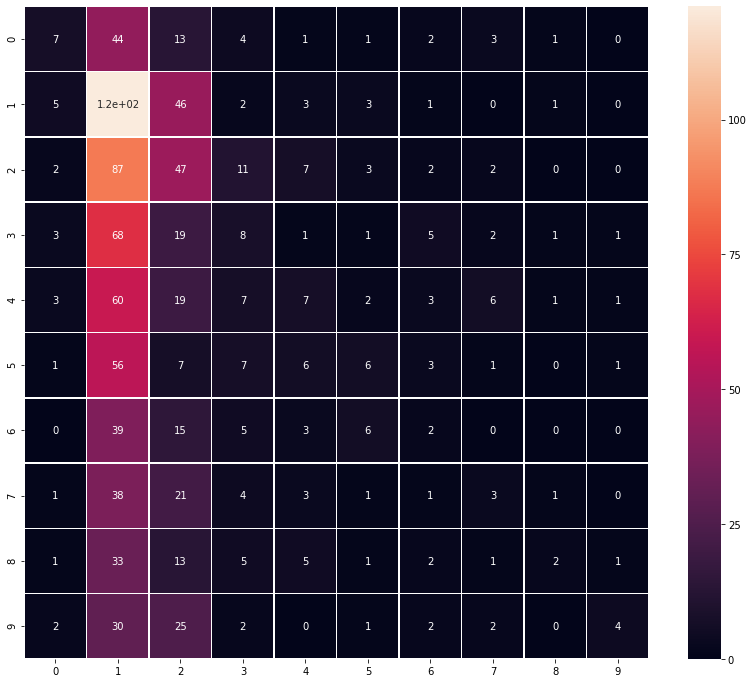

In [213]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_matr_data = confusion_matrix(test_y, test_pred)

fig, ax = plt.subplots(figsize=(14, 12))
ax = sns.heatmap(conf_matr_data, linewidth=0.5, annot=True,)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
fig.show()